# Species classification by whistles, Oswald data
# Expt 3: AUDIO CLIP split;  cross-validation

# May  19, 2021

In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, LSTM, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D  # Reshape, Lambda, Concatenate
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy  # CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
# import tensorflow_addons.layers.spatial_pyramid_pooling as spp
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

from lib_validation import DataGenerator, find_best_model
from lib_model import model_cnn14_spp, model_cnn14_attention_multi

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Hyper parameters

# 77.24 val for STAR2000
learning_rate = 1.e-4
conv_dim = 64
pool_size = 2
pool_stride = 2
l2_regu = 0.0001
drop_rate = 0.2
hidden_units = 512
fcn_dim = 512

# # A little bit l2
# learning_rate = 1.e-4
# conv_dim = 64
# pool_size = 2
# pool_stride = 2
# l2_regu = 0.0001  ==>> good, but need fine-tuning
# l2_regu = 0.001   ==>> too much!
# drop_rate = 0.2
# hidden_units = 512
# fcn_dim = 512

num_epoch = 200
# num_epoch = 1  # debug
# batch_size = 128
batch_size = 32  # for cnn14+attention
# batch_size = 16  # for cnn14+spp
copies_of_aug =  10

num_patience = 20

num_fold = 5

In [4]:
root_dir = '/home/ys587/__Data/__whistle'  # where we have __whislte_30_species folder
# root_dir = '/home/ubuntu'  # where we have __whislte_30_species folder

work_path = os.path.join(root_dir, '__whistle_30_species')
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
# feature_path = os.path.join(work_path, '__dataset/20210210')

In [5]:
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
num_species = len(species_dict)
species_list = list(species_dict.keys())
species_id = list(species_dict.values())

## Features

In [6]:
feature_path = os.path.join(root_dir, '__whistle_30_species/__dataset/__feature')

In [7]:
# df_species = pd.read_csv(os.path.join(feature_path, 'all.csv'))
df_species = pd.read_csv(os.path.join(feature_path, 'all_species.csv'))
df_noise = pd.read_csv(os.path.join(feature_path, 'all_noise.csv'))

## Split over clips

In [8]:
today = datetime.now()
# create a folder based on date & time
# fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))
fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S')+'_clip_run'+str(run_num))

In [9]:
label_pred_all = []
label_test_all = []

In [10]:
## fold split over clips

In [11]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=num_fold)

In [12]:
# k-fold split
fea_temp_orig = np.load(os.path.join(feature_path, 'all_orig.npz'))
# feas_orig = fea_temp_orig['feas_orig']
labels_orig = fea_temp_orig['labels_orig']
del fea_temp_orig

random_list = [0, 10, 20, 30, 40]
fold_id = 0
for train_set, test_set in skf.split(np.arange(labels_orig.shape[0]), labels_orig):
    print('Fold '+str(fold_id)+':')
    print('train_set')
    print(train_set)
    print('test_set')
    print(test_set)
    
    # (a) testing
    # loading
    fea_temp_orig = np.load(os.path.join(feature_path, 'all_orig.npz'))
    feas_orig = fea_temp_orig['feas_orig']
    labels_orig = fea_temp_orig['labels_orig']
    print('The shape of feas_orig: ', end='')
    print(feas_orig.shape)
    
    # fea_test = feas_orig[test_set, :, :]  ## << ==
    fea_test = feas_orig[list(test_set), :, :]  ## replace ndarray by list
    label_test = labels_orig[list(test_set)]
    label_test = np.array([species_dict[ll] for ll in label_test])
    print('')
    print(len(test_set))
    print(fea_test.shape)
    print('')
    
    del feas_orig, labels_orig

    # (b) training
    # loading
    fea_temp_aug = np.load(os.path.join(feature_path, 'all_aug.npz'))
    feas_aug = fea_temp_aug['feas_aug']
    labels_aug = fea_temp_aug['labels_aug']
    print('The shape of feas_aug: ', end='')
    print(feas_aug.shape)

    # augmented features & labels
    fea_ind_aug = []
    for ff in list(train_set):
        for ii in range(copies_of_aug):
            fea_ind_aug.append(ff*copies_of_aug+ii)
        
    fea_train = feas_aug[fea_ind_aug, :, :]
    label_train = labels_aug[fea_ind_aug]
    label_train = np.array([species_dict[ll] for ll in label_train])
    print('')
    print(len(train_set))
    print(fea_train.shape)
    print('')
    
    del feas_aug, labels_aug
    
    # summary
    print('feature train shape: '+str(fea_train.shape))
    print('feature test shape: '+str(fea_test.shape))
    print('label train shape: '+str(label_train.shape))
    print('label test shape: '+str(label_test.shape))

    dim_time = fea_train.shape[1]
    dim_freq = fea_train.shape[2]
    print('dim_time: '+str(dim_time))
    print('dim_freq: '+str(dim_freq))
    
    # shuffle features & labels
    fea_train, label_train = shuffle(fea_train, label_train, random_state=random_list[fold_id])
    fea_test, label_test = shuffle(fea_test, label_test, random_state=random_list[fold_id])
    
    fea_train = np.expand_dims(fea_train, axis=3)
    fea_test = np.expand_dims(fea_test, axis=3)
    
    fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.10, random_state=random_list[fold_id])

    train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
    del fea_train
    validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
    del fea_validate
    
    # deployment folder
    fit_result_path2 = os.path.join(fit_result_path1, 'fold'+str(fold_id))
    if not os.path.exists(fit_result_path2):
        makedirs(fit_result_path2)
        
    # class weight
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

    class_weights = dict()
    for ii in range(num_species):
        class_weights[ii] = weights[ii]
        
    ### Training the model
    # model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
    model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
    # loss = categorical_crossentropy
    loss = binary_crossentropy
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])
    # model.summary()

    # With classes
    # history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
    # history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
    # history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])
    # history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])
    history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

    # Testing
    the_best_model, _ = find_best_model(fit_result_path2, purge=False)
    model = load_model(the_best_model)
    label_pred = model.predict(fea_test)

    # save the testing results
    np.savez(os.path.join(fit_result_path1, 'fold'+str(fold_id)+'_test_results.npz'), label_test=label_test, label_pred=label_pred)
    
    label_pred_all.append(label_pred)
    label_test_all.append(label_test)
    
    del train_generator, validate_generator
    
    fold_id += 1

Fold 0:
train_set
[  432   433   434 ... 20071 20072 20073]
test_set
[    0     1     2 ... 17918 17919 17920]
The shape of feas_orig: (20074, 101, 128)

4015
(4015, 101, 128)

The shape of feas_aug: (200740, 101, 128)

16059
(160590, 101, 128)

feature train shape: (160590, 101, 128)
feature test shape: (4015, 101, 128)
label train shape: (160590,)
label test shape: (4015,)
dim_time: 101
dim_freq: 128
Epoch 1/200
9033/9033 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.3051
Epoch 00001: val_accuracy improved from -inf to 0.41744, saving model to /home/ys587/__Data/__whistle/__whistle_30_species/__fit_result_species/20210523_204759/fold0/epoch_01_valloss_0.3380_valacc_0.4174.hdf5
9033/9033 [==============================] - 544s 60ms/step - loss: 0.4754 - accuracy: 0.3051 - val_loss: 0.3380 - val_accuracy: 0.4174
Epoch 2/200
9033/9033 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.4550
Epoch 00002: val_accuracy did not improve from 0.41

In [13]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 101, 128, 1)]     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 101, 128, 64)      640       
_________________________________________________________________
batch_normalization_52 (Batc (None, 101, 128, 64)      256       
_________________________________________________________________
activation_52 (Activation)   (None, 101, 128, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 101, 128, 64)      36928     
_________________________________________________________________
batch_normalization_53 (Batc (None, 101, 128, 64)      256       
_________________________________________________________________
activation_53 (Activation)   (None, 101, 128, 64)      0   

In [14]:
label_pred_all = np.concatenate(label_pred_all)
label_test_all = np.concatenate(label_test_all)

In [15]:
label_test_all.shape

(20074,)

## Confusion matrix

In [16]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [17]:
print("Confusion matrix:")
# cm = confusion_matrix(label_train[:label_train_pred.shape[0]], np.argmax(label_train_pred, axis=1), labels=species_id)
cm = confusion_matrix(label_test_all, np.argmax(label_pred_all, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[1242  150  318  142  159   65   51   33]
 [  22 3088  840  474   59   95   87   50]
 [ 117  655 1515  112  105   54   60   73]
 [ 267  315  312 1167  137  139   39   16]
 [ 183  195  184   52  396    7   95   11]
 [ 108  168  110   18   21 1502   51  186]
 [  57   75   25   16   45   71  897  218]
 [  19   34   42    7    5  246  206 2866]]

[[0.57 0.07 0.15 0.07 0.07 0.03 0.02 0.02]
 [0.   0.65 0.18 0.1  0.01 0.02 0.02 0.01]
 [0.04 0.24 0.56 0.04 0.04 0.02 0.02 0.03]
 [0.11 0.13 0.13 0.49 0.06 0.06 0.02 0.01]
 [0.16 0.17 0.16 0.05 0.35 0.01 0.08 0.01]
 [0.05 0.08 0.05 0.01 0.01 0.69 0.02 0.09]
 [0.04 0.05 0.02 0.01 0.03 0.05 0.64 0.16]
 [0.01 0.01 0.01 0.   0.   0.07 0.06 0.84]]


In [18]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

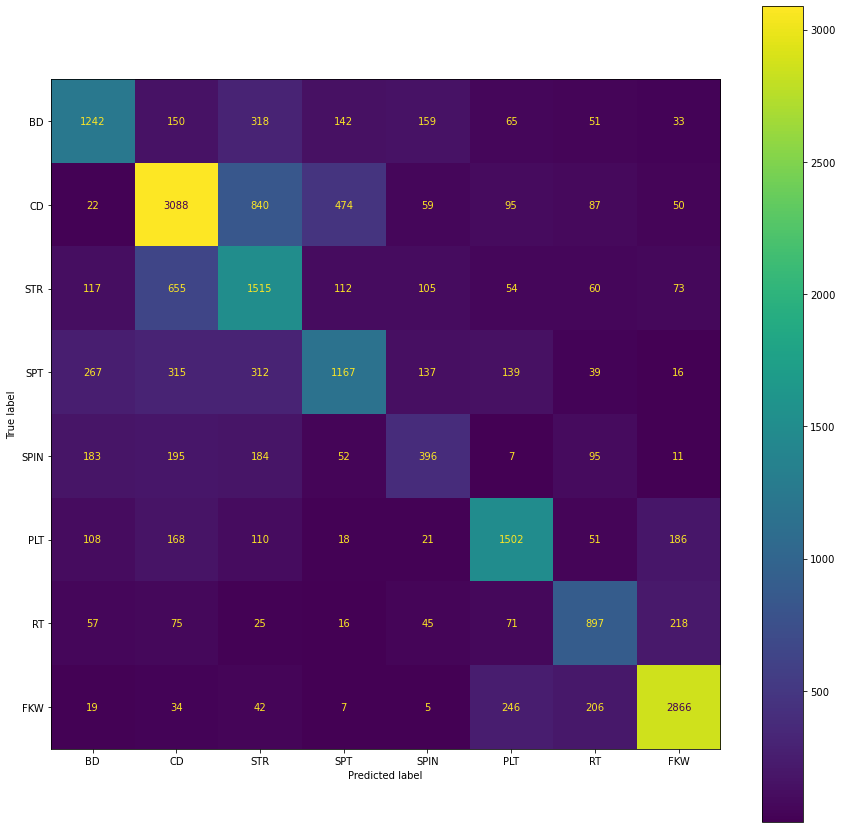

In [19]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


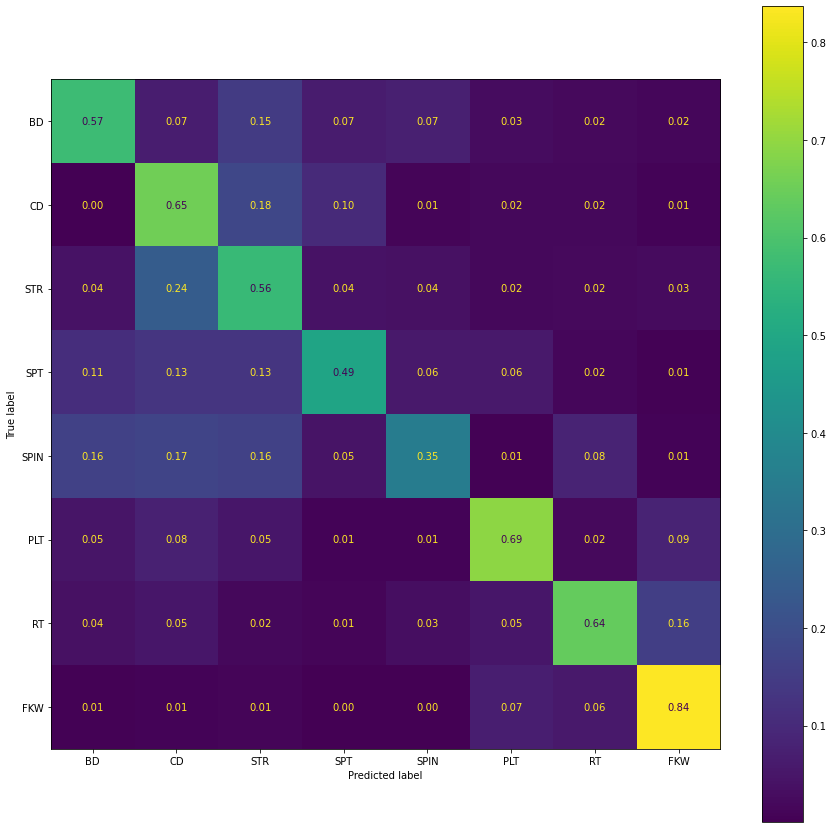

In [20]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)